In [1]:
%matplotlib inline

from imports import *
from matplotlib.patches import ConnectionPatch
np.set_printoptions(suppress=True)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [42]:
source  = '/home/sobolev/nevermind/Andrey/data'
#source  = '/home/andrey/projects/data/'
report = '/home/sobolev/nevermind/Andrey/analysis/PPC'

characteristic_units = [
    ['008229_hippoSIT_2022-05-17_21-44-43', '8-8'],
    ['008229_hippoSIT_2022-05-16_20-36-44', '8-17'],
    ['008229_hippoSIT_2022-05-20_15-54-39', '3-17'],
    ['008229_hippoSIT_2022-05-18_14-36-18', '8-18'],
    ['009266_hippoSIT_2023-04-26_08-20-17', '6-4'],
]

characteristic_assemblies = [
    ['008229_hippoSIT_2022-05-17_21-44-43', 6, 6.5],
    ['008229_hippoSIT_2022-05-16_20-36-44', 7, 9],
    ['008229_hippoSIT_2022-05-20_15-54-39', 11, 1.2],
    ['008229_hippoSIT_2022-05-18_14-36-18', 6, 15]
]

#session, ass_id, thresh = characteristic_assemblies[3]
session, unit_id = characteristic_units[3]
thresh = 7

animal  = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5name  = os.path.join(source, animal, session, session + '.h5')
#report = sessionpath

## Target behavior in active or passive listening states

In [43]:
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
    #i_rate = np.array(f['assemblies'][str(ass_id)])
    i_rate = np.array(f['units'][str(unit_id)]['inst_rate'])

Text(0.5, 1.0, '2022-05-18_14-36-18')

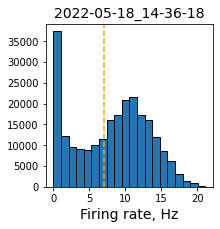

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.hist(i_rate, bins=20, edgecolor='black')
ax.axvline(thresh, color='orange', ls='--')
ax.set_xlabel('Firing rate, Hz', fontsize=14)
ax.set_title(session[-19:], fontsize=14)

In [45]:
len(i_rate), len(np.where(i_rate > 2.5)[0])

(240001, 187143)

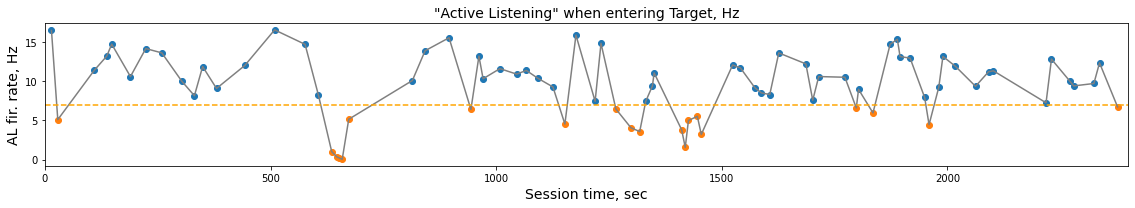

In [46]:
# compute active listening periods
off_al = 3  # secs
s_rate = 100  # sampling rate 100 Hz

# select entrances to the target
min_dur = 0  # min duration in target, sec. 0 means all entrances to target
idxs_target  = np.where(tl[:, 6] == 2)[0]
idxs_to_idx1 = np.where(np.diff(idxs_target) > 5)[0] + 1 # target starts
idxs_to_idx2 = np.where(np.diff(idxs_target) > 5)[0][1:] # target ends
idxs_to_idx  = np.where(idxs_to_idx2 - idxs_to_idx1[:-1] > min_dur * 100)[0]
idxs_tgt_start = idxs_target[:-1][idxs_to_idx1[idxs_to_idx]]

fr_before_tgt = np.array([i_rate[idx-off_al*s_rate:idx+off_al*s_rate].mean() for idx in idxs_tgt_start])
x_vals = tl[idxs_tgt_start][:, 0]

idxs_act = np.where(fr_before_tgt > thresh)[0]
idxs_pas = np.where(fr_before_tgt < thresh)[0]

# average active listening rate (Hz) when entering the island
fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(111)
ax.plot(x_vals, fr_before_tgt, color='gray')
ax.scatter(x_vals[idxs_act], fr_before_tgt[idxs_act], color=COLORS[0])
ax.scatter(x_vals[idxs_pas], fr_before_tgt[idxs_pas], color=COLORS[1])
ax.axhline(thresh, ls='--', color='orange')
ax.set_xlim(tl[0][0], tl[-1][0])
ax.set_xlabel('Session time, sec', fontsize=14)
ax.set_ylabel('AL fir. rate, Hz', fontsize=14)
ax.set_title('"Active Listening" when entering Target, Hz', fontsize=14)
fig.tight_layout()
#fig.savefig(os.path.join(report, 'AL_TGT_%s_ASS_%s.png' % (session, ass_id)))

NameError: name 'ass_id' is not defined

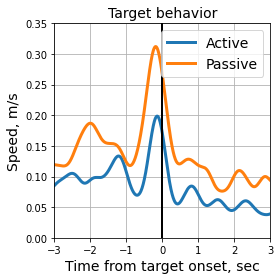

In [47]:
fig = plt.figure(figsize=(4,4))

offset = 100 * 3  # 3 seconds
x_vals = np.linspace(-offset/s_rate, offset/s_rate, 2*offset)
labels = ['Active', 'Passive']

idxs_active  = idxs_tgt_start[fr_before_tgt > thresh]
idxs_passive = idxs_tgt_start[fr_before_tgt < thresh]

width = 100  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)
s_smooth = np.convolve(tl[:, 3], kernel, 'same') / kernel.sum()

ax = fig.add_subplot(1, 1, 1)
for i, var_idxs in enumerate([idxs_active, idxs_passive]):
    # TODO add averages /stds
    x_coll, y_coll = [], []
    for idx in var_idxs:
        idx_x_l =  0 if idx - offset > 0 else offset - idx
        idx_x_r = len(x_vals) if idx + offset < len(i_rate) else offset + len(i_rate) - idx - 1
        idx_y_l =  0 if idx - offset < 0 else idx - offset
        idx_y_r = -1 if idx + offset > len(i_rate) else idx + offset
        #ax.plot(x_vals[idx_x_l:idx_x_r], s_smooth[idx_y_l:idx_y_r], color=COLORS[i], alpha=0.6)
        x_coll.append(x_vals[idx_x_l:idx_x_r])
        y_coll.append(s_smooth[idx_y_l:idx_y_r])
        
    y_coll = np.array(y_coll)
    mean_vals = y_coll.sum(axis=0)/len(y_coll)
    ax.plot(x_vals[idx_x_l:idx_x_r], mean_vals, color=COLORS[i], lw=3, label=labels[i])
    
    #conf_int_high = np.percentile(y_coll, 84.1, axis=0) - np.mean(y_coll, axis=0)
    #conf_int_low  = np.percentile(y_coll, 15.9, axis=0) - np.mean(y_coll, axis=0)
    #ax.fill_between(x_vals[idx_x_l:idx_x_r], mean_vals + conf_int_low, mean_vals + conf_int_high, color=COLORS[i], alpha=0.3)

ax.set_xlim(-offset/s_rate, offset/s_rate)
ax.set_ylim(0, 0.35)
ax.axvline(0, linewidth=2, color='black')
ax.set_title("Target behavior", fontsize=14)
ax.set_xlabel('Time from target onset, sec', fontsize=14)
ax.set_ylabel('Speed, m/s', fontsize=14)
ax.legend(loc="upper right", fontsize=14)
ax.grid(b=True)
fig.tight_layout()
fig.savefig(os.path.join(report, 'Speed_TGT_%s_%s.png' % (session, ass_id)))

- Peak at zero is here because gerbil moves in short sprints in general
- difference in speed at the entrance may point to more focused behavior
- higher speeds after 1 sec from entering the island in passive listening state show high chance to leave the target

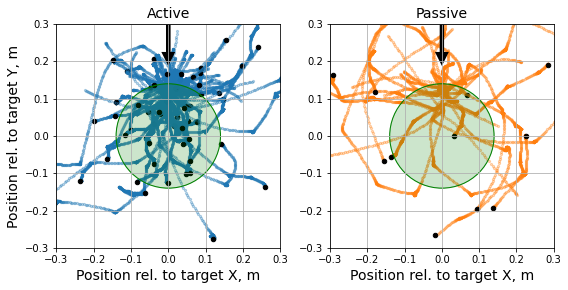

In [192]:
off_before = 0.5
off_after  = 4

phi_d = np.pi/2
fig = plt.figure(figsize=(8, 4))
labels = ['Active', 'Passive']

for i, idxs in enumerate([idxs_active, idxs_passive]):
    ax = fig.add_subplot(1,2,i+1)
    
    for idx in idxs:
        curr_trial = trials[int(tl[idx][5]) - 1]
        #alpha = 0.3 if curr_trial == 1
        tgt_x, tgt_y = curr_trial[2], curr_trial[3]
        x = tl[idx - int(off_before*s_rate):idx + int(off_after*s_rate)][:, 1] - tgt_x
        y = tl[idx - int(off_before*s_rate):idx + int(off_after*s_rate)][:, 2] - tgt_y
        
        idx_enter_tgt = int(off_before*s_rate)
        rho, phi = cart2pol(x[idx_enter_tgt], y[idx_enter_tgt])
       
        rot_angle = -phi + phi_d
        x_rot = x*np.cos(rot_angle) - y*np.sin(rot_angle)
        y_rot = x*np.sin(rot_angle) + y*np.cos(rot_angle)
        
        ax.scatter(x_rot, y_rot, s=5, color=COLORS[i], alpha=0.3)
        ax.scatter(x_rot[-1], y_rot[-1], s=20, color='black')

    ax.add_patch(plt.Circle((0, 0), 0.14, color='green', fill=True, alpha=0.2))
    ax.add_patch(plt.Circle((0, 0), 0.14, color='green', fill=False))
    ax.grid()
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    ax.set_aspect('equal')
    ax.set_title(labels[i], fontsize=14)
    ax.set_xlabel('Position rel. to target X, m', fontsize=14)
    if i == 0:
        ax.set_ylabel('Position rel. to target Y, m', fontsize=14)
        
    ax.arrow(0, 0.3, 0, -0.08, lw=4, head_width=0.02, head_length=0.02, fc='k', ec='k')
    
fig.tight_layout()
fig.savefig(os.path.join(report, 'Traj_TGT_%s_ASS_%s.png' % (session, ass_id)))

## Performance when active listening

In [155]:
# indices of rewards
off_rew = 5 # offset to compute FR before reward
idxs_reward = trials[trials[:, 5] == 1][:, 1].astype(np.int32)
fr_before_rew = np.array([i_rate[idx-off_rew*s_rate:idx].mean() for idx in idxs_reward])

Text(0.5, 1.0, '"Active Listening" before reward, Hz')

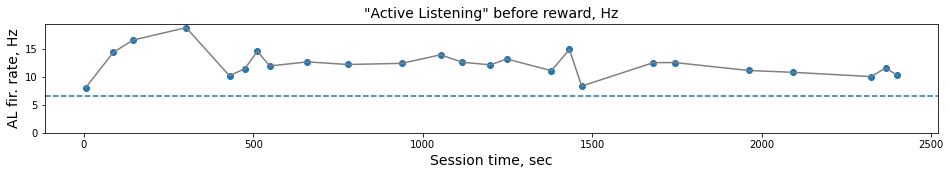

In [156]:
x_vals = tl[idxs_reward][:, 0]

fig = plt.figure(figsize=(16, 2))
ax = fig.add_subplot(111)
ax.plot(x_vals, fr_before_rew, color='gray')
ax.scatter(x_vals, fr_before_rew, color=COLORS[0])
ax.axhline(thresh, ls='--')
ax.set_ylim(0, fr_before_tgt.max() + 0.2)
ax.set_xlabel('Session time, sec', fontsize=14)
ax.set_ylabel('AL fir. rate, Hz', fontsize=14)
ax.set_title('"Active Listening" before reward, Hz', fontsize=14)

## State before reward, for multiple sessions

In [159]:
per_session = {}

for ss, ass_id, th in characteristic_assemblies:
    h5name  = os.path.join(source, animal, ss, ss + '.h5')
    with h5py.File(h5name, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
        trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
        i_rate = np.array(f['assemblies'][str(ass_id)])
    
    off_rew = 5 # offset to compute FR before reward
    idxs_reward = trials[trials[:, 5] == 1][:, 1].astype(np.int32)
    fr_before_rew = np.array([i_rate[idx-off_rew*s_rate:idx].mean() for idx in idxs_reward])
    active  = len(fr_before_rew[fr_before_rew > th])
    passive = len(fr_before_rew[fr_before_rew < th])
    
    per_session[ss] = (active, passive)

Text(0.5, 1.0, 'State before reward')

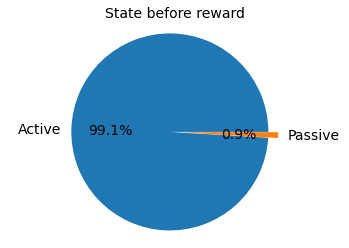

In [161]:
active  = np.array([int(val[0]) for val in per_session.values()]).sum()
passive = np.array([int(val[1]) for val in per_session.values()]).sum()
labels  = ['Active', 'Passive']
sizes   = [active, passive]
explode = (0, 0.1)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, \
       startangle=0, textprops={'fontsize': 14})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('State before reward', fontsize=14)

In [84]:
## Show that the speed in passive is in general higher (excluding pellet searching periods OR all ITI)

In [86]:
## Show that active state is spatially localized to the center, but passive (or some other state) to the boundaries

## Decorrelation with speed

In [59]:
# TODO